## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [1]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
    
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [2]:
def draw_graph():
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = model(re.float()).item() + U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [3]:
def cal_loss():
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = model(re.float()).item() + U_groundtruth(re)
            #?????????
            if re[0] ** 2 + re[1] ** 2 < 1 : 
                mmm += abs(z[i, j])
    
    return mmm / (xl * yl)

In [4]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

In [5]:
"""
Train with the grid
"""

model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()
                
for k in range(400):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0  epoch, loss:  -0.17077522
0  epoch, regularization loss:  0.1284964
0  loss to real solution:  0.0016028039865195742
1  epoch, loss:  -0.21008307
1  epoch, regularization loss:  0.14798751
1  loss to real solution:  0.002487806079536675
2  epoch, loss:  -0.25304854
2  epoch, regularization loss:  0.17378932
2  loss to real solution:  0.0019377750799059862
3  epoch, loss:  -0.29149172
3  epoch, regularization loss:  0.19934046
3  loss to real solution:  0.0030126388669013972
4  epoch, loss:  -0.31714
4  epoch, regularization loss:  0.21523681
4  loss to real solution:  0.0020688510715961453
5  epoch, loss:  -0.33033574
5  epoch, regularization loss:  0.22015531
5  loss to real solution:  0.002498530906438827
6  epoch, loss:  -0.33325103
6  epoch, regularization loss:  0.21475846
6  loss to real solution:  0.0027738092064857477
7  epoch, loss:  -0.33039176
7  epoch, regularization loss:  0.20365126
7  loss to real solution:  0.0014544580101966858
8  epoch, loss:  -0.323862
8  epoch, r

67  epoch, loss:  -0.19620043
67  epoch, regularization loss:  0.07530739
67  loss to real solution:  0.0009422978058457376
68  epoch, loss:  -0.19346617
68  epoch, regularization loss:  0.07345811
68  loss to real solution:  0.0009171214371919634
69  epoch, loss:  -0.19359823
69  epoch, regularization loss:  0.07422076
69  loss to real solution:  0.0009073999196290972
70  epoch, loss:  -0.19853884
70  epoch, regularization loss:  0.080054685
70  loss to real solution:  0.0009340865582227708
71  epoch, loss:  -0.19924301
71  epoch, regularization loss:  0.08141034
71  loss to real solution:  0.0009302126660943033
72  epoch, loss:  -0.19434708
72  epoch, regularization loss:  0.077119365
72  loss to real solution:  0.0008904058158397676
73  epoch, loss:  -0.18741526
73  epoch, regularization loss:  0.070883945
73  loss to real solution:  0.0008378749012947084
74  epoch, loss:  -0.183044
74  epoch, regularization loss:  0.06735706
74  loss to real solution:  0.0008041017547249796
75  epo

133  epoch, loss:  -0.12634802
133  epoch, regularization loss:  0.042764865
133  loss to real solution:  0.00045180581435561197
134  epoch, loss:  -0.124327585
134  epoch, regularization loss:  0.041166447
134  loss to real solution:  0.0004401152946054937
135  epoch, loss:  -0.12022161
135  epoch, regularization loss:  0.037552886
135  loss to real solution:  0.0003922888875007631
136  epoch, loss:  -0.119658664
136  epoch, regularization loss:  0.03722218
136  loss to real solution:  0.00038305456340312973
137  epoch, loss:  -0.12196073
137  epoch, regularization loss:  0.039841272
137  loss to real solution:  0.000393904657661915
138  epoch, loss:  -0.12661412
138  epoch, regularization loss:  0.04503925
138  loss to real solution:  0.0004254517883062364
139  epoch, loss:  -0.12353249
139  epoch, regularization loss:  0.04220184
139  loss to real solution:  0.000393438468873501
140  epoch, loss:  -0.11632613
140  epoch, regularization loss:  0.035440665
140  loss to real solution: 

KeyboardInterrupt: 

In [8]:
a = torch.ones(1, requires_grad=True)
b =a 
b.backward()
a.grad

tensor([ 1.])

In [ ]:
# Calculate time for grid method
start = time.time()
for k in range(10):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
stop = time.time()
print(stop - start)

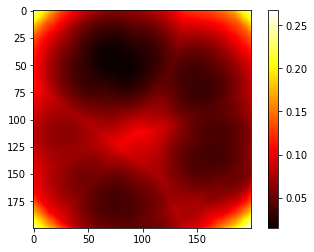

0.0004983906134963036

In [6]:
torch.save(model.state_dict(), '2/model.pkl')
draw_graph()
cal_loss()